# Exam project - Amigos - Covid Business Intelligence

### Imports

In [903]:
import pandas as pd

In [904]:
import numpy as np
import math

In [905]:
import seaborn as sns
import matplotlib.pyplot as plt

In [906]:
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import preprocessing as prep
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [907]:
# Uncomment the line below to install the folium package
# %conda install folium

In [908]:
import folium

### Reader

In [909]:
# Reading the file can take a while - it's 86000 rows :-)
data = pd.read_excel(".\Data\CovidDeaths.xlsx")

In [910]:
#show the first and last 5 rows of data

### Cleaner

In [911]:
#List of all tables to be removed
kolonner_til_fjernelse = [
    'new_cases_smoothed', 'total_cases_per_million', 
    'new_cases_per_million', 'new_vaccinations_smoothed', 'new_cases_smoothed_per_million', 'new_deaths_smoothed', 
    'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 
    'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 
    'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 
    'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests', 
    'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 
    'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 
    'people_vaccinated', 'people_fully_vaccinated', 'total_vaccinations_per_hundred', 
    'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 
    'new_vaccinations_smoothed_per_million', 
    # removed after looking at the corr matrix (heatmap)
    'aged_70_older', 'diabetes_prevalence', 'extreme_poverty', 'stringency_index',
]

# Remove the specified tables
clean = data.drop(kolonner_til_fjernelse, axis=1)

In [912]:
# Set Total vaccinations to 0 if NaN
clean['total_vaccinations'].fillna(0, inplace=True)

In [913]:
# Set Total Deaths to 0 if NaN
clean['total_deaths'].fillna(0, inplace=True)

In [914]:
# Set new Vaccinations to 0 if NaN
clean['new_vaccinations'].fillna(0, inplace=True) 

In [915]:
# Set new Vaccinations to 0 if NaN
clean['new_cases'].fillna(0, inplace=True) 

In [916]:
# Set new Vaccinations to 0 if NaN
clean['new_deaths'].fillna(0, inplace=True) 

In [917]:
# Set Total Cases to 0 if NaN
clean['total_cases'].fillna(0, inplace=True)

In [918]:
# Fix total_vaccinations weirdly high values (numE+09)
# clean[clean['iso_code'].str.contains('OWID_')]['total_vaccinations']

Next we fix OWID(Our World in Data) data, to have the same format as the other data sources.

In [919]:
OWID_Rows = clean[clean['iso_code'].str.contains('OWID_')]
OWID_Rows['continent'].fillna(clean[clean['iso_code'].str.contains('OWID_')]['location'], inplace=True)
OWID_Rows['location'] = 'Whole_Continent'

C:\Users\Cat\AppData\Local\Temp\ipykernel_13420\1974715526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OWID_Rows['continent'].fillna(clean[clean['iso_code'].str.contains('OWID_')]['location'], inplace=True)
C:\Users\Cat\AppData\Local\Temp\ipykernel_13420\1974715526.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OWID_Rows['location'] = 'Whole_Continent'


In [920]:
OWID_Rows.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_vaccinations', 'new_vaccinations',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'gdp_per_capita', 'cardiovasc_death_rate', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

In [921]:
columns_to_fillna_with_avg = [
    'population', 'population_density', 'median_age', 
    'aged_65_older', 'gdp_per_capita',
    'cardiovasc_death_rate', 'female_smokers',
    'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
    'life_expectancy', 'human_development_index'
    ]
# there is 9 OWID "continents"
continents = OWID_Rows['continent'].unique()

for continent in continents:
    for column in columns_to_fillna_with_avg:
        OWID_Rows[column].fillna(clean[clean['continent'] == continent][column].mean(), inplace=True)

C:\Users\Cat\AppData\Local\Temp\ipykernel_13420\1490184435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OWID_Rows[column].fillna(clean[clean['continent'] == continent][column].mean(), inplace=True)


In [922]:
OWID_Rows

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,new_vaccinations,...,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
432,OWID_AFR,Africa,Whole_Continent,2020-02-13,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,21.129073,3.685116,5508.122067,287.374602,2.57387,27.424106,25.493713,1.506984,64.242507,0.562094
433,OWID_AFR,Africa,Whole_Continent,2020-02-14,1.0,1.0,0.0,0.0,0.000000e+00,0.0,...,21.129073,3.685116,5508.122067,287.374602,2.57387,27.424106,25.493713,1.506984,64.242507,0.562094
434,OWID_AFR,Africa,Whole_Continent,2020-02-15,1.0,0.0,0.0,0.0,0.000000e+00,0.0,...,21.129073,3.685116,5508.122067,287.374602,2.57387,27.424106,25.493713,1.506984,64.242507,0.562094
435,OWID_AFR,Africa,Whole_Continent,2020-02-16,1.0,0.0,0.0,0.0,0.000000e+00,0.0,...,21.129073,3.685116,5508.122067,287.374602,2.57387,27.424106,25.493713,1.506984,64.242507,0.562094
436,OWID_AFR,Africa,Whole_Continent,2020-02-17,1.0,0.0,0.0,0.0,0.000000e+00,0.0,...,21.129073,3.685116,5508.122067,287.374602,2.57387,27.424106,25.493713,1.506984,64.242507,0.562094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83964,OWID_WRL,World,Whole_Continent,2021-04-26,147872402.0,682784.0,3120469.0,11156.0,1.045371e+09,16393996.0,...,30.900000,8.696000,15469.207000,233.070000,6.43400,34.635000,60.130000,2.705000,72.580000,0.737000
83965,OWID_WRL,World,Whole_Continent,2021-04-27,148716872.0,844470.0,3134956.0,14487.0,1.065139e+09,19768227.0,...,30.900000,8.696000,15469.207000,233.070000,6.43400,34.635000,60.130000,2.705000,72.580000,0.737000
83966,OWID_WRL,World,Whole_Continent,2021-04-28,149622864.0,905992.0,3150675.0,15719.0,1.087697e+09,22557773.0,...,30.900000,8.696000,15469.207000,233.070000,6.43400,34.635000,60.130000,2.705000,72.580000,0.737000
83967,OWID_WRL,World,Whole_Continent,2021-04-29,150520466.0,897602.0,3165665.0,14990.0,1.112321e+09,24623727.0,...,30.900000,8.696000,15469.207000,233.070000,6.43400,34.635000,60.130000,2.705000,72.580000,0.737000


In [923]:
# Add OWID data back into DataFrame
clean = clean.drop(OWID_Rows.index)
clean = pd.concat([clean, OWID_Rows], ignore_index=False)

In [924]:
# Remove countries with almost no data
countries_to_remove = [
    'Anguilla', 'Vatican', 'Antigua and Barbuda',
    'Cayman Islands', 'Curacao', 'Dominica', 
    'Falkland Islands', 'Guernsey', 'Isle of Man', 
    'Jersey', 'Liechtenstein', 'Marshall Islands',
    'Montserrat', 'Northern Cyprus', 'Saint Kitts and Nevis', 
    'Saint Helena', 'Saint Lucia', 'Saint Vincent and the Grenadines',
    'Turks and Caicos Islands','Gibraltar', 'Nauru', 'Greenland',
    'Aruba', 'Bermuda', 'Faeroe Islands', 'Macao',
    'Monaco', 'San Marino'
    ]
clean = clean[~clean['location'].isin(countries_to_remove)]

In [925]:
# fillna stringency_index foreach country with the mean of the stringency_index for the country
#countries_names = clean['location'].unique()
#for country in countries_names:
    #contry_rows = clean[clean['location'] == country]
    #clean = clean.drop(contry_rows.index)
    #mean = contry_rows['stringency_index'].mean()
    #cleaned = contry_rows.fillna(mean, inplace=False)
    #clean = pd.concat([clean, cleaned], ignore_index=False)


In [926]:
# Set the rest of stringency_index nan to 0
#clean['stringency_index'].fillna(0, inplace=True)

In [927]:
#Removing the rows with missing values

In [928]:
clean.drop(['handwashing_facilities', 'hospital_beds_per_thousand'], axis=1, inplace=True)

In [929]:
#clean['diabetes_prevalence'].fillna(0, inplace=True)

In [930]:
columns_to_fillna_with_avg = ['male_smokers', 'female_smokers']

for column in columns_to_fillna_with_avg:
    clean[column].fillna(clean[column].mean(), inplace=True)
    print(f"Filled {column} with mean")

Filled male_smokers with mean
Filled female_smokers with mean


In [931]:
# https://ourworldindata.org/grapher/total-population-in-extreme-poverty?tab=chart&country=MDV
# According to the above link, Maldives has 0% extreme poverty 
#clean.loc[clean['location'] == 'Maldives', 'extreme_poverty'] = clean.loc[clean['location'] == 'Maldives', 'extreme_poverty'].fillna(0)

In [932]:
# https://borgenproject.org/poverty-in-grenada/
# According to the above link, Grenada has 13% extreme poverty
#clean.loc[clean['location'] == 'Grenada', 'extreme_poverty'] = clean.loc[clean['location'] == 'Grenada', 'extreme_poverty'].fillna(0.13)

In [933]:
# https://futures.issafrica.org/geographic/countries/equatorial-guinea/
# According to the above link, Equatorial Guinea has 83.2% extreme poverty
#clean.loc[clean['location'] == 'Equatorial Guinea', 'extreme_poverty'] = clean.loc[clean['location'] == 'Equatorial Guinea', 'extreme_poverty'].fillna(0.832)

In [934]:
# https://globaldatalab.org/shdi/table/shdi/SOM/?levels=1+4&interpolation=0&extrapolation=0
# According to the above link, Somalia has 0.361 human development index
clean.loc[clean['location'] == 'Somalia', 'human_development_index'] = clean.loc[clean['location'] == 'Somalia', 'human_development_index'].fillna(0.361)

In [935]:
# https://en.populationdata.net/rankings/hdi/asia/
# According to the above link, Taiwan has 0.907 human development index
clean.loc[clean['location'] == 'Taiwan', 'human_development_index'] = clean.loc[clean['location'] == 'Taiwan', 'human_development_index'].fillna(0.907)

In [936]:
# https://www.worldometers.info/world-population/south-sudan-population/
# According to the above link, south sudan has 18 population_density
clean.loc[clean['location'] == 'South Sudan', 'population_density'] = clean.loc[clean['location'] == 'South Sudan', 'population_density'].fillna(18)

In [937]:
# https://www.worldometers.info/world-population/syria-population/
# According to the above link, Syria has 116.5 population_density (we took estimated population density between the years  2020 and 2022)
clean.loc[clean['location'] == 'Syria', 'population_density'] = clean.loc[clean['location'] == 'Syria', 'population_density'].fillna(116.5)

In [938]:
# https://www.worldometers.info/world-population/taiwan-population/
# According to the above link, south Taiwan has 674 population_density (we took estimated population density between the years  2020 and 2022)
clean.loc[clean['location'] == 'Taiwan', 'population_density'] = clean.loc[clean['location'] == 'Taiwan', 'population_density'].fillna(674)

In [939]:
# https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=AD
# According to the above link, south Andorra has 41992.8 gdp_per_capita
clean.loc[clean['location'] == 'Andorra', 'gdp_per_capita'] = clean.loc[clean['location'] == 'Andorra', 'gdp_per_capita'].fillna(41992.8)

In [940]:
# https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=AD
# According to the above link, Andorra has 41992.8 gdp_per_capita
clean.loc[clean['location'] == 'Andorra', 'gdp_per_capita'] = clean.loc[clean['location'] == 'Andorra', 'gdp_per_capita'].fillna(41992.8)

In [941]:
# https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=CU
# According to the above link, Cuba has 9499.6 gdp_per_capita
clean.loc[clean['location'] == 'Cuba', 'gdp_per_capita'] = clean.loc[clean['location'] == 'Cuba', 'gdp_per_capita'].fillna(9499.6)

In [942]:
# https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?end=2022&locations=SO&start=1960&view=chart
# According to the above link, Somalia has 592.1 gdp_per_capita
clean.loc[clean['location'] == 'Somalia', 'gdp_per_capita'] = clean.loc[clean['location'] == 'Somalia', 'gdp_per_capita'].fillna(592.1)

In [943]:
# https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?end=2022&locations=SY&start=1960&view=chart
# According to the above link, Syria has 420.6 gdp_per_capita
clean.loc[clean['location'] == 'Syria', 'gdp_per_capita'] = clean.loc[clean['location'] == 'Syria', 'gdp_per_capita'].fillna(420.6)

In [944]:
# https://www.statista.com/statistics/727592/gross-domestic-product-gdp-per-capita-in-taiwan/
# According to the above link, Taiwan has 33186.34 gdp_per_capita
clean.loc[clean['location'] == 'Taiwan', 'gdp_per_capita'] = clean.loc[clean['location'] == 'Taiwan', 'gdp_per_capita'].fillna(33186.34)

In [945]:
# find the avg of cardiovasc_death_rate in asia and fillna with it on hong kong
asian_cardiovasc_death_rate_avg = clean[clean['continent'] == 'Asia']['cardiovasc_death_rate'].mean()
clean.loc[clean['location'] == 'Hong Kong', 'cardiovasc_death_rate'] = clean.loc[clean['location'] == 'Hong Kong', 'cardiovasc_death_rate'].fillna(asian_cardiovasc_death_rate_avg)

In [946]:
# https://www.prb.org/resources/countries-with-the-oldest-populations-in-the-world/
# According to the above link, Andorra has 14.4 aged_65_older
clean.loc[clean['location'] == 'Andorra', 'aged_65_older'] = clean.loc[clean['location'] == 'Andorra', 'aged_65_older'].fillna(14.4)

In [947]:
# https://data.worldbank.org/indicator/SP.POP.65UP.TO.ZS?locations=SY
# According to the above link, Syria has 5 aged_65_older
clean.loc[clean['location'] == 'Syria', 'aged_65_older'] = clean.loc[clean['location'] == 'Syria', 'aged_65_older'].fillna(5)

In [948]:
# https://www.statista.com/statistics/321439/taiwan-population-distribution-by-age-group/
# According to the above link, Taiwan has 17.56 aged_65_older
clean.loc[clean['location'] == 'Taiwan', 'aged_65_older'] = clean.loc[clean['location'] == 'Taiwan', 'aged_65_older'].fillna(17.56)

In [949]:
# https://datareportal.com/reports/digital-2023-andorra
# According to the above link, Andorra has 17.56 aged_65_older
clean.loc[clean['location'] == 'Andorra', 'median_age'] = clean.loc[clean['location'] == 'Andorra', 'median_age'].fillna(43.3)

In [950]:
#Vi mangler noget her :))
clean.isnull().sum()

iso_code                   0
continent                  0
location                   0
date                       0
total_cases                0
new_cases                  0
total_deaths               0
new_deaths                 0
total_vaccinations         0
new_vaccinations           0
population                 0
population_density         0
median_age                 0
aged_65_older              0
gdp_per_capita             0
cardiovasc_death_rate      0
female_smokers             0
male_smokers               0
life_expectancy            0
human_development_index    0
dtype: int64

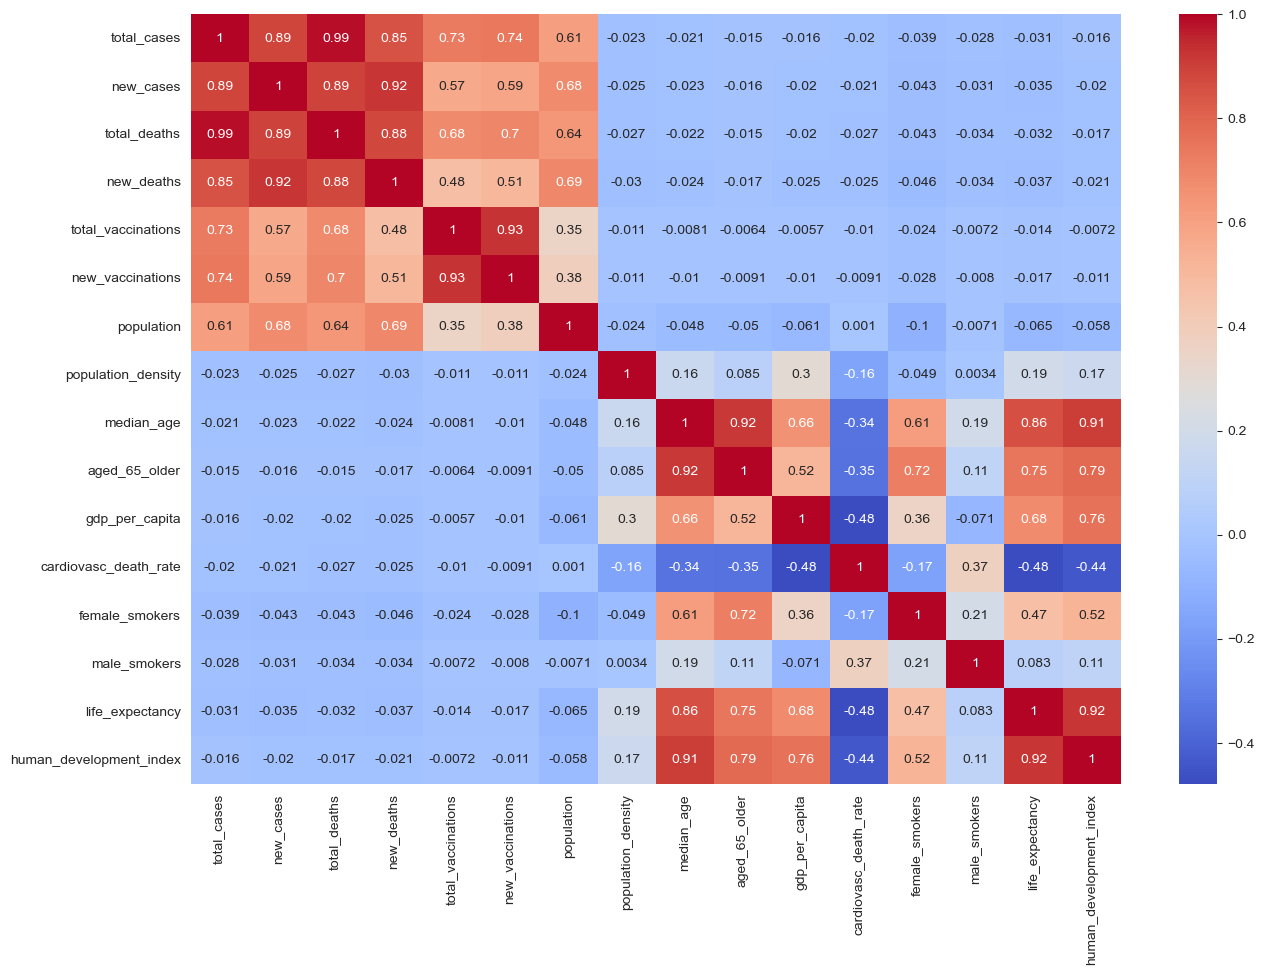

In [951]:
# heatmap of the correlation matrix
columns_to_keep_out = ['iso_code', 'continent', 'location', 'date']
corraltion_matrix_data = clean.loc[:, ~clean.columns.isin(columns_to_keep_out)]
plt.subplots(figsize=(15,10))
heatmap = sns.heatmap(corraltion_matrix_data.corr(), annot=True, cmap="coolwarm")


In [952]:
testing_data = clean[['location', 'median_age']]

for i in testing_data.values:
    if math.isnan(i[1]):
        print(i)


In [953]:
# Save the updated sheet
clean.to_excel(".\Data\CovidDeaths_cleaned.xlsx", index=False)

### Methods

In [954]:
#Removing all duplicates (if any)
def removeDuplicates(df):
    df.drop_duplicates(inplace=True)
    return df

### Exploring the data

In [955]:
# hvor mange kolonner/rækker har vi?
data.shape

(85171, 59)

In [956]:
#samlet shape når vi har aggregated to data sæt (data + et given lands data)
#showShape(combined_data)